# **Final Assignment - "Battle of the Neighborhoods"**

## *Introduction/Business Problem*

In some of the previous labs and assignments, we had the opportunity to work with the location data of New York and Toronto to make clusters based on venue categories in neighborhoods. Also, in prior sections of the course, we were required to work with and analyze crime data of Chicago and San Francisco. Combining these two ideas together and applying it to my home city of Atlanta, Georgia, United States, I am going to attempt to determine whether we can find any correlation between the alcohol/weapon venue categories in a neighborhood and the number of crimes or types of crimes in the neighborhood. I will also perform exploratory data analysis as I work through the project and ideas come to mind. This project would be of particular interest to anyone who is curious about the relation between alcohol/weapon venues-types of a location and crime of that location. The police department, venue owners, or social workers may also be interested in the results of this study as it may provide insights relative to their fields. It will be interesting to have an "unbiased" look; for example, when we are in a particular location we automatically make assumptions based on the appearance of the buildings, infrastructure, people, etc. However, this study will not so much be looking at the perceived quality of the venues, but on the pattern of venue occurrence. I may also look in to venue ratings once clusters are made to explore whether a lower average rating of venues has any correlation to crime.

Previous studies have shown that higher density of bars/liquor stores have higher rates of violent crime, so I will investigate whether this holds true for Atlanta.
http://resources.prev.org/documents/alcoholviolencegruenewald.pdf

## *Data Description/Examples*

***Atlanta Data*** - I will use Wikipedia to get data concerning Atlanta neighborhoods and NPUs(Neighborhood Planning Unit, geographically based). Conveniently, the crime data I will use includes the latitude and longitude of the crime in addition to the neighborhood name and NPU, so I will take the mean lat/long for crimes in a given neighborhood to determine its coordinates(to be used with Foursquare API). Finally, I will use the open data csv files from the Atlanta Police Department to acquire crime data; for simplicity, we will only use the crime data for 2018.

https://en.wikipedia.org/wiki/Neighborhood_planning_unit

http://opendata.atlantapd.org/Crimedata/Default.aspx


#### Import packages to be used

*Note: I will create a CSV for some of the data manually, and I will web-parse for some of the data as well.*

In [1]:
from bs4 import BeautifulSoup
import requests
import urllib
import urllib.request

import pandas as pd
import numpy as np

#### Read csv file (manually constructed using Wikipedia)

NPU csv file containing the neighborhood name and the respective NPU

In [2]:
df_npu = pd.read_csv('NPU.csv')
print(df_npu.shape)
df_npu.head()

(242, 2)


,NPU,Neighborhood
0,A,Chastain Park
1,A,Kingswood
2,A,Margaret Mitchell
3,A,Mt. Paran Parkway
4,A,Mt. Paran/Northside


#### Import crime data and clean dataframe

Because the crime data is stored by month, we will first need to concatenate all the crime data into a single dataframe before we merge the dataframes together

In [3]:
df_crime = pd.read_csv('Jan18.csv')
month_list = ['Feb', 'Mar', 'Apr', 'May', "Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in month_list:
    month_csv = '{}18.csv'.format(month)
    df_month = pd.read_csv(month_csv)
    frames = [df_crime, df_month]
    df_crime = pd.concat(frames, sort=False)
print(df_crime.shape)


(25622, 10)


In [4]:
df_crime.head()

,UC2_Literal,Report Number,Report Date,Location,Beat,Neigborhood,NPU,Lat,Long,Unnamed: 9
0,LARCENY-FROM VEHICLE,180310061,01/31/2018,691 PENN AVE NE,505.0,Midtown,E,33.77338,-84.37856,NaN
1,LARCENY-FROM VEHICLE,180310146,01/31/2018,543 STOKESWOOD AVE SE,612.0,East Atlanta,W,33.73949,-84.34501,NaN
2,LARCENY-FROM VEHICLE,180310161,01/31/2018,437 MORELAND AVE NE,608.0,Candler Park,N,33.76632,-84.34892,NaN
3,LARCENY-FROM VEHICLE,180310488,01/31/2018,976 GILBERT ST SE,607.0,Ormewood Park,W,33.72787,-84.35055,NaN
4,LARCENY-FROM VEHICLE,180310584,01/31/2018,2470 CHESHIRE BRIDGE RD NE,212.0,Lindridge/Martin Manor,F,33.82236,-84.35173,NaN


We will do not need the report number, date, location, beat, or unnamed: 9 columns for our study so we can drop those

In [5]:
df_crime.drop(['Report Number', 'Report Date', 'Location', 'Beat', 'Unnamed: 9'], axis=1, inplace=True)
print(df_crime.shape)
df_crime.head()

(25622, 5)


,UC2_Literal,Neigborhood,NPU,Lat,Long
0,LARCENY-FROM VEHICLE,Midtown,E,33.77338,-84.37856
1,LARCENY-FROM VEHICLE,East Atlanta,W,33.73949,-84.34501
2,LARCENY-FROM VEHICLE,Candler Park,N,33.76632,-84.34892
3,LARCENY-FROM VEHICLE,Ormewood Park,W,33.72787,-84.35055
4,LARCENY-FROM VEHICLE,Lindridge/Martin Manor,F,33.82236,-84.35173


Drop rows with NaN

In [6]:
atl_crime = df_crime
print('Shape with NaN values:', atl_crime.shape)
atl_crime = atl_crime.dropna()
print('Shape without NaN values:', atl_crime.shape)
atl_crime = atl_crime.rename(columns={'UC2_Literal':'Type'})
atl_crime.head()

Shape with NaN values: (25622, 5)
Shape without NaN values: (24708, 5)


,Type,Neigborhood,NPU,Lat,Long
0,LARCENY-FROM VEHICLE,Midtown,E,33.77338,-84.37856
1,LARCENY-FROM VEHICLE,East Atlanta,W,33.73949,-84.34501
2,LARCENY-FROM VEHICLE,Candler Park,N,33.76632,-84.34892
3,LARCENY-FROM VEHICLE,Ormewood Park,W,33.72787,-84.35055
4,LARCENY-FROM VEHICLE,Lindridge/Martin Manor,F,33.82236,-84.35173


In [7]:
df_coord = atl_crime.groupby(['Neigborhood','NPU']).mean().reset_index()
print(df_coord.shape)
print(df_coord.columns)
df_coord.head()

(240, 4)
Index(['Neigborhood', 'NPU', 'Lat', 'Long'], dtype='object')


,Neigborhood,NPU,Lat,Long
0,Adair Park,V,33.730508,-84.410038
1,Adams Park,I,33.717640,-84.469230
2,Adams Park,R,33.714968,-84.461356
3,Adamsville,H,33.759220,-84.503682
4,Almond Park,G,33.783619,-84.460499


#### Search for Duplicates

In [8]:
duplicates = pd.concat(g for _, g in df_coord.groupby("Neigborhood") if len(g) > 1)
duplicates

,Neigborhood,NPU,Lat,Long
1,Adams Park,I,33.717640,-84.469230
2,Adams Park,R,33.714968,-84.461356
15,Atlanta University Center,M,33.748890,-84.404530
16,Atlanta University Center,T,33.752156,-84.413525
103,Grant Park,N,33.743620,-84.358200
104,Grant Park,W,33.739281,-84.369418
186,Reynoldstown,N,33.751498,-84.353080
187,Reynoldstown,O,33.752420,-84.349220
211,Tuxedo Park,A,33.853535,-84.391393
212,Tuxedo Park,B,33.848050,-84.391240


In [9]:
dup_list = duplicates['Neigborhood'].tolist()
dup_list = set(dup_list)
for hood in dup_list:
    print(df_npu.loc[df_npu['Neighborhood'] == hood])

  NPU Neighborhood
8   A  Tuxedo Park
    NPU  Neighborhood
142   N  Reynoldstown
    NPU Neighborhood
210   W   Grant Park
    NPU               Neighborhood
194   T  Atlanta University Center
    NPU Neighborhood
181   R   Adams Park
    NPU    Neighborhood
192   S  Venetian Hills


I cross referenceed the NPU dataframe to verify correct NPU for neighborhoods that show differing NPUs for the same neighborhood

|Hood|Correct NPU|
| --- | --- |
|Adams Park|R|
|Tuxedo Park|A|
|Reynoldstown|N|
|Grant Park|W|
|Atlanta University Center|T|
|Venetian Hills|S|


#### Remove duplicates from df_coord

In [10]:
hoods = ['Adams Park', 'Tuxedo Park', "Reynoldstown", 'Grant Park', 'Atlanta University Center', 'Venetian Hills']
npu_correct = ['R', 'A', 'N', 'W' ,'T' ,'S']
for hood, npu in zip(hoods, npu_correct):
    i = df_coord[((df_coord.Neigborhood == hood) &( df_coord.NPU != npu))].index
    df_coord = df_coord.drop(i)
df_coord.rename(index = str, columns={'Neigborhood':'Neighborhood'}, inplace = True)

df_coord = df_coord.reset_index()
df_coord.drop('index', axis=1, inplace = True)
print(df_coord.shape)
df_coord.head(10)

(234, 4)


,Neighborhood,NPU,Lat,Long
0,Adair Park,V,33.730508,-84.410038
1,Adams Park,R,33.714968,-84.461356
2,Adamsville,H,33.759220,-84.503682
3,Almond Park,G,33.783619,-84.460499
4,Amal Heights,Y,33.708469,-84.398998
5,Ansley Park,E,33.793170,-84.378400
6,Arden/Habersham,C,33.838003,-84.401703
7,Ardmore,E,33.804271,-84.394102
8,Argonne Forest,C,33.841271,-84.403490
9,Arlington Estates,P,33.691722,-84.539251


##### **We now have our neighborhood-information dataset**

With 234 out of the 242 Atlanta neighborhoods(including all neighborhoods where a crime was recorded), and I am confident in the ability of the dataset in searching for correlations. Although we will not be using neighborhoods where there was no crime, that is not too relevant as our aim is to see if there is a correlation between venue-types and crime quantity/type.

#### Remove duplicates from atl_crime

Now that I know there are incorrect values in our atl_crime dataframe, I'll fix it by the same process already used.

In [11]:
hoods = ['Adams Park', 'Tuxedo Park', "Reynoldstown", 'Grant Park', 'Atlanta University Center', 'Venetian Hills']
npu_correct = ['R', 'A', 'N', 'W' ,'T' ,'S']
for hood, npu in zip(hoods, npu_correct):
    i = atl_crime[((atl_crime.Neigborhood == hood) &( atl_crime.NPU != npu))].index
    atl_crime = atl_crime.drop(i)
atl_crime.rename(index = str, columns={'Neigborhood':'Neighborhood'}, inplace = True)

atl_crime = atl_crime.reset_index()
atl_crime.drop('index', axis=1, inplace = True)
print(atl_crime.shape)
atl_crime.head(10)

(24631, 5)


,Type,Neighborhood,NPU,Lat,Long
0,LARCENY-FROM VEHICLE,Midtown,E,33.77338,-84.37856
1,LARCENY-FROM VEHICLE,East Atlanta,W,33.73949,-84.34501
2,LARCENY-FROM VEHICLE,Candler Park,N,33.76632,-84.34892
3,LARCENY-FROM VEHICLE,Ormewood Park,W,33.72787,-84.35055
4,LARCENY-FROM VEHICLE,Lindridge/Martin Manor,F,33.82236,-84.35173
5,LARCENY-FROM VEHICLE,Sweet Auburn,M,33.75912,-84.37260
6,LARCENY-FROM VEHICLE,Midtown,E,33.78346,-84.37931
7,LARCENY-FROM VEHICLE,Browns Mill Park,Z,33.68156,-84.39458
8,LARCENY-FROM VEHICLE,Campbellton Road,R,33.70530,-84.46047
9,LARCENY-FROM VEHICLE,Lenox,B,33.84676,-84.36212


##### **We now have our crime dataset**

The crime dataset was minimally reduced while cleaning the data so I think it serves as a very good dataset to work with for our study with respect to 2018 crime in Atlanta

***Foursquare API*** - I will make use of the Foursquare API to obtain location data with respect to the neighborhood latitudes and longitudes. We will use this in combination with the other dataframes we have formed to search for correlations in venue-types and crime.

#### Define Foursqaure Credentials

In [12]:
CLIENT_ID = 'BQXM0NHEJLDDRQE5VX1U10E1VOXRVXRMH1I2N30LZJDVSY5W' # your Foursquare ID
CLIENT_SECRET = 'R22G1UF3WEP2F0YYYJ4MY2MSN4ODZRLDRKJKAU10WGFMYIJW' # your Foursquare Secret
VERSION = '20190308' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BQXM0NHEJLDDRQE5VX1U10E1VOXRVXRMH1I2N30LZJDVSY5W
CLIENT_SECRET:R22G1UF3WEP2F0YYYJ4MY2MSN4ODZRLDRKJKAU10WGFMYIJW


#### Import Libraries

In [13]:
from geopy.geocoders import Nominatim
import folium
import json
import requests
from pandas.io.json import json_normalize

In [14]:
address = 'Atlanta, Georgia'

geolocator = Nominatim(user_agent="atlanta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Atlanta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Atlanta are 33.7490987, -84.3901849.


#### Define function to get location data for every neighborhood

We'll search for the top 100 venues within 800 meters(half-mile). This is a difficult parameter to set. The city of Atlanta is 134 square miles, with 242 neighborhoods. Assuming they are equally spaced apart(I know they are not, but for the sake of standardization), each neighborhood is approximately .55 square miles. Therefore we'll search for venues using the latitude and longitude for the [crime] center of the neighborhood.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
atlanta_venues = getNearbyVenues(names=df_coord['Neighborhood'],
                                   latitudes=df_coord['Lat'],
                                   longitudes=df_coord['Long']
                                  )

Adair Park
Adams Park
Adamsville
Almond Park
Amal Heights
Ansley Park
Arden/Habersham
Ardmore
Argonne Forest
Arlington Estates
Ashley Courts
Ashview Heights
Atkins Park
Atlanta Industrial Park
Atlanta University Center
Atlantic Station
Audobon Forest
Audobon Forest West
Baker Hills
Bakers Ferry
Bankhead
Bankhead/Bolton
Beecher Hills
Ben Hill
Ben Hill Acres
Ben Hill Forest
Ben Hill Pines
Ben Hill Terrace
Benteen Park
Berkeley Park
Betmar LaVilla
Blair Villa/Poole Creek
Blandtown
Bolton
Bolton Hills
Boulder Park
Boulevard Heights
Brandon
Brentwood
Briar Glen
Brookhaven
Brookview Heights
Brookwood
Brookwood Hills
Browns Mill Park
Buckhead Forest
Buckhead Heights
Buckhead Village
Bush Mountain
Butner/Tell
Cabbagetown
Campbellton Road
Candler Park
Capitol Gateway
Capitol View
Capitol View Manor
Carey Park
Carroll Heights
Carver Hills
Cascade Avenue/Road
Cascade Green
Cascade Heights
Castleberry Hill
Castlewood
Center Hill
Chalet Woods
Channing Valley
Chastain Park
Chosewood Park
Collier Hei

In [17]:
print(atlanta_venues.shape)
atlanta_venues.head(10)

(4884, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adair Park,33.730508,-84.410038,Adair Park One,33.730525,-84.412837,Park
1,Adair Park,33.730508,-84.410038,Boxcar Atl,33.729955,-84.417383,Gastropub
2,Adair Park,33.730508,-84.410038,Monday Night Garage,33.729407,-84.418303,Brewery
3,Adair Park,33.730508,-84.410038,Atlanta BeltLine Corridor under Lee/Murphy,33.727205,-84.417238,Trail
4,Adair Park,33.730508,-84.410038,Atlanta Beltline Westside Trail,33.726212,-84.413658,Trail
5,Adair Park,33.730508,-84.410038,Studioplexx47,33.736314,-84.409719,Event Space
6,Adair Park,33.730508,-84.410038,Goot Enterprises,33.725440,-84.406100,Real Estate Office
7,Adair Park,33.730508,-84.410038,The Bakery,33.724926,-84.414390,Art Gallery
8,Adair Park,33.730508,-84.410038,angel park,33.724010,-84.412287,Park
9,Adair Park,33.730508,-84.410038,Ok Yaki,33.729375,-84.418087,Pop-Up Shop


##### **We now have our venues dataframe**

## *Methodolgy*

There are multiple steps that must be completed irrespective of order before we can look for a correlation of venue-types and crime relative to neighborhoods. The venues data will be explored and clustered into neighborhoods of similar venue-types. The crime data will also be analyzed to determine the neighborhoods with the most crime and the most frequent types of crime committed city-wide. I will also cluster neighborhoods by overall crime and violent crimes.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

### **Crime Data**

#### Neighborhoods with the Most Crime in 2018

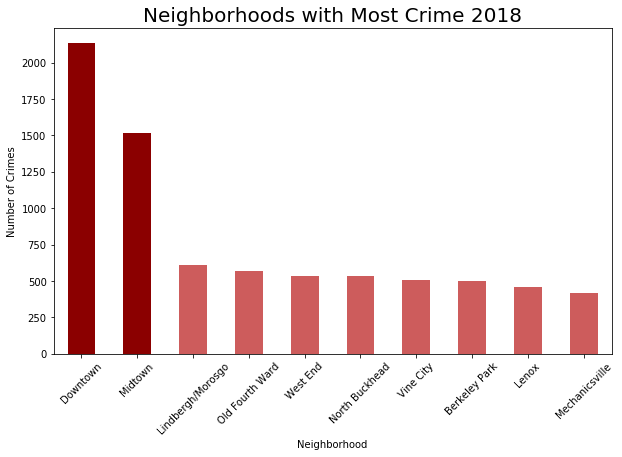

In [19]:
hood_crime = atl_crime['Neighborhood'].value_counts()
hood_crime10 = hood_crime[0:10]

top_10 = hood_crime10.plot(kind='bar', color = 'indianred',figsize=(10, 6))
top_10.patches[hood_crime10.index.get_indexer(['Downtown'])[0]].set_facecolor('darkred')
top_10.patches[hood_crime10.index.get_indexer(['Midtown'])[0]].set_facecolor('darkred')

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Crimes') # add y-label to the plot
plt.title('Neighborhoods with Most Crime 2018', fontsize = 20)
plt.xticks(rotation=45)

plt.show()


In [20]:
print('There are {} unique crime types.'.format(len(atl_crime['Type'].unique())))

There are 11 unique crime types.


#### ***Analyze Each Neighborhood***

In [21]:
# one hot encoding
atl_onehot = pd.get_dummies(atl_crime[['Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atl_onehot['Neighborhood'] = atl_crime['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atl_onehot.columns[-1]] + list(atl_onehot.columns[:-1])
atl_onehot = atl_onehot[fixed_columns]

atl_onehot.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
0,Midtown,0,0,0,0,0,1,0,0,0,0,0
1,East Atlanta,0,0,0,0,0,1,0,0,0,0,0
2,Candler Park,0,0,0,0,0,1,0,0,0,0,0
3,Ormewood Park,0,0,0,0,0,1,0,0,0,0,0
4,Lindridge/Martin Manor,0,0,0,0,0,1,0,0,0,0,0


In [22]:
num_crimes = pd.DataFrame(atl_onehot['Neighborhood'].value_counts()).reset_index()
num_crimes.rename(columns={'Neighborhood':'Count','index':'Neighborhood'}, inplace=True)
num_crimes.head()

,Neighborhood,Count
0,Downtown,2134
1,Midtown,1514
2,Lindbergh/Morosgo,607
3,Old Fourth Ward,567
4,West End,536


In [23]:
# group by mean frequency
atl_crime_grouped = atl_onehot.groupby('Neighborhood').mean().reset_index()
atl_crime_grouped.head(10)

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000
5,Ansley Park,0.018519,0.129630,0.018519,0.037037,0.000000,0.574074,0.185185,0.0,0.000000,0.037037,0.000000
6,Arden/Habersham,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,Ardmore,0.000000,0.095890,0.013699,0.000000,0.000000,0.794521,0.082192,0.0,0.000000,0.013699,0.000000
8,Argonne Forest,0.142857,0.142857,0.000000,0.285714,0.000000,0.285714,0.142857,0.0,0.000000,0.000000,0.000000
9,Arlington Estates,0.222222,0.222222,0.000000,0.074074,0.000000,0.296296,0.185185,0.0,0.000000,0.000000,0.000000


In [24]:
def return_most_common_crimes(row, num_top_crimes):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_crimes]

In [25]:
num_top_crimes = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_crimes):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

# create a new dataframe
atl_crime_sorted1 = pd.DataFrame(columns=columns)
atl_crime_sorted1['Neighborhood'] = atl_crime_grouped['Neighborhood']

for ind in np.arange(atl_crime_grouped.shape[0]):
    atl_crime_sorted1.iloc[ind, 1:] = return_most_common_crimes(atl_crime_grouped.iloc[ind, :], num_top_crimes)

atl_crime_sorted1.head(10)

,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,Adair Park,LARCENY-FROM VEHICLE,AUTO THEFT,LARCENY-NON VEHICLE,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,MANSLAUGHTER
1,Adams Park,LARCENY-NON VEHICLE,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,MANSLAUGHTER
2,Adamsville,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,AUTO THEFT,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-RESIDENCE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,HOMICIDE
3,Almond Park,BURGLARY-RESIDENCE,AUTO THEFT,LARCENY-FROM VEHICLE,ROBBERY-PEDESTRIAN,AGG ASSAULT,LARCENY-NON VEHICLE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,HOMICIDE,ROBBERY-RESIDENCE
4,Amal Heights,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-RESIDENCE,AGG ASSAULT,LARCENY-NON VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE
5,Ansley Park,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,AUTO THEFT,ROBBERY-PEDESTRIAN,BURGLARY-RESIDENCE,BURGLARY-NONRES,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,MANSLAUGHTER
6,Arden/Habersham,LARCENY-FROM VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,LARCENY-NON VEHICLE,HOMICIDE,BURGLARY-RESIDENCE,BURGLARY-NONRES,AUTO THEFT
7,Ardmore,LARCENY-FROM VEHICLE,AUTO THEFT,LARCENY-NON VEHICLE,ROBBERY-PEDESTRIAN,BURGLARY-NONRES,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE,BURGLARY-RESIDENCE
8,Argonne Forest,LARCENY-FROM VEHICLE,BURGLARY-RESIDENCE,LARCENY-NON VEHICLE,AUTO THEFT,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE
9,Arlington Estates,LARCENY-FROM VEHICLE,AUTO THEFT,AGG ASSAULT,LARCENY-NON VEHICLE,BURGLARY-RESIDENCE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE


#### Clustering Neighborhoods by Crime: KMeans, DBSCAN

##### **KMeans**
*Finding optimal k*

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

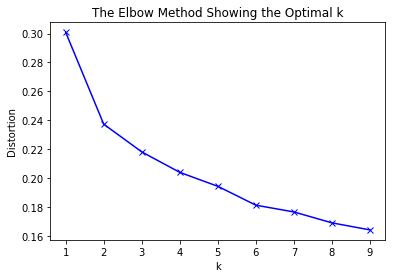

In [27]:
# k means determine k
atl_grouped_clustering = atl_crime_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=4).fit(atl_grouped_clustering)
    kmeanModel.fit(atl_grouped_clustering)
    distortions.append(sum(np.min(cdist(atl_grouped_clustering,\
                                        kmeanModel.cluster_centers_, 'euclidean'),\
                                        axis=1)) / atl_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()



So, k=2 is our optimal k value

##### Clustering Neighborhoods

In [28]:
# set number of clusters
kclusters = 2

atl_grouped_clustering = atl_crime_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0], dtype=int32)

In [29]:
# add clustering labels
atl_crime_sorted1.insert(0, 'Cluster Labels', kmeans.labels_)

atl_merged = df_coord

# merge atl_grouped with toronto_data to add latitude/longitude for each neighborhood
atl_merged = atl_merged.join(atl_crime_sorted1.set_index('Neighborhood'), on='Neighborhood')

atl_merged.head()

,Neighborhood,NPU,Lat,Long,Cluster Labels,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,Adair Park,V,33.730508,-84.410038,0,LARCENY-FROM VEHICLE,AUTO THEFT,LARCENY-NON VEHICLE,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,MANSLAUGHTER
1,Adams Park,R,33.714968,-84.461356,0,LARCENY-NON VEHICLE,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,MANSLAUGHTER
2,Adamsville,H,33.759220,-84.503682,0,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,AUTO THEFT,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-RESIDENCE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,HOMICIDE
3,Almond Park,G,33.783619,-84.460499,0,BURGLARY-RESIDENCE,AUTO THEFT,LARCENY-FROM VEHICLE,ROBBERY-PEDESTRIAN,AGG ASSAULT,LARCENY-NON VEHICLE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,HOMICIDE,ROBBERY-RESIDENCE
4,Amal Heights,Y,33.708469,-84.398998,0,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-RESIDENCE,AGG ASSAULT,LARCENY-NON VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE


##### Visualize Results

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atl_merged['Lat'], atl_merged['Long'], atl_merged['Neighborhood'], atl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### **Examine Clusters**

In [32]:
clus1 = atl_merged.loc[atl_merged['Cluster Labels'] == 0, atl_merged.columns[[0] + list(range(5, atl_merged.shape[1]))]]
clus1.head()

,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,Adair Park,LARCENY-FROM VEHICLE,AUTO THEFT,LARCENY-NON VEHICLE,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,MANSLAUGHTER
1,Adams Park,LARCENY-NON VEHICLE,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,MANSLAUGHTER
2,Adamsville,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,AUTO THEFT,AGG ASSAULT,ROBBERY-PEDESTRIAN,BURGLARY-RESIDENCE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,ROBBERY-RESIDENCE,HOMICIDE
3,Almond Park,BURGLARY-RESIDENCE,AUTO THEFT,LARCENY-FROM VEHICLE,ROBBERY-PEDESTRIAN,AGG ASSAULT,LARCENY-NON VEHICLE,BURGLARY-NONRES,ROBBERY-COMMERCIAL,HOMICIDE,ROBBERY-RESIDENCE
4,Amal Heights,LARCENY-FROM VEHICLE,AUTO THEFT,BURGLARY-RESIDENCE,AGG ASSAULT,LARCENY-NON VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE


In [33]:
clus2 = atl_merged.loc[atl_merged['Cluster Labels'] == 1, atl_merged.columns[[0] + list(range(5, atl_merged.shape[1]))]]
clus2.head()

,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
5,Ansley Park,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,AUTO THEFT,ROBBERY-PEDESTRIAN,BURGLARY-RESIDENCE,BURGLARY-NONRES,AGG ASSAULT,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,MANSLAUGHTER
6,Arden/Habersham,LARCENY-FROM VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,LARCENY-NON VEHICLE,HOMICIDE,BURGLARY-RESIDENCE,BURGLARY-NONRES,AUTO THEFT
7,Ardmore,LARCENY-FROM VEHICLE,AUTO THEFT,LARCENY-NON VEHICLE,ROBBERY-PEDESTRIAN,BURGLARY-NONRES,ROBBERY-RESIDENCE,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE,BURGLARY-RESIDENCE
12,Atkins Park,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,HOMICIDE,BURGLARY-RESIDENCE,BURGLARY-NONRES,AUTO THEFT
13,Atlanta Industrial Park,LARCENY-FROM VEHICLE,BURGLARY-NONRES,BURGLARY-RESIDENCE,ROBBERY-RESIDENCE,ROBBERY-PEDESTRIAN,ROBBERY-COMMERCIAL,MANSLAUGHTER,LARCENY-NON VEHICLE,HOMICIDE,AUTO THEFT


It is interesting to note that overall cluster 1 seems to encompass North/East Atlanta and cluster 2 appears to cover more of South/West Atlanta.

##### **DBSCAN**

In [34]:
pdf = atl_crime_grouped
pdf['Lat'] = atl_merged['Lat']
pdf['Long'] = atl_merged['Long']
#pdf.drop(['Clus_Db'], axis=1, inplace=True)
print(pdf.shape)
pdf.head(10)

(234, 14)


,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998
5,Ansley Park,0.018519,0.129630,0.018519,0.037037,0.000000,0.574074,0.185185,0.0,0.000000,0.037037,0.000000,33.793170,-84.378400
6,Arden/Habersham,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,33.838003,-84.401703
7,Ardmore,0.000000,0.095890,0.013699,0.000000,0.000000,0.794521,0.082192,0.0,0.000000,0.013699,0.000000,33.804271,-84.394102
8,Argonne Forest,0.142857,0.142857,0.000000,0.285714,0.000000,0.285714,0.142857,0.0,0.000000,0.000000,0.000000,33.841271,-84.403490
9,Arlington Estates,0.222222,0.222222,0.000000,0.074074,0.000000,0.296296,0.185185,0.0,0.000000,0.000000,0.000000,33.691722,-84.539251


In [35]:
#!conda install -c conda-forge basemap-data-hires --y

##### Visualizing Neighborhood Distribution with Basemap

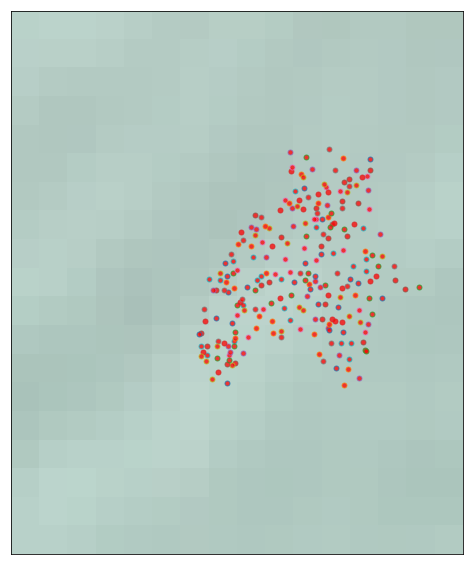

In [36]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-84.75
ulon=-84.25
llat=33.5
ulat=34

pdf_location = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc', lat_0 = latitude, lon_0 = longitude,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-84.75, llcrnrlat=33.5,
                 urcrnrlon=-84.25, urcrnrlat=34)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf_location['xm']= xs.tolist()
pdf_location['ym'] =ys.tolist()

#Visualization1
for index,row in pdf_location.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()

##### Clustering Neighborhoods based on location

In [87]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = pdf_location[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.35, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf_loc = pdf
pdf_loc["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
#pdf[["Neighborhood","Tx","Tm","Clus_Db"]].head(5)
pdf_loc.head(5)

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,0
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,4
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,1


In [88]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5}

In [89]:
pdf_loc['Clus_Db'].value_counts()

 2    55
-1    48
 1    46
 0    32
 3    29
 4    16
 5     8
Name: Clus_Db, dtype: int64

In [90]:
pdf_location2 = pdf_location
pdf_location2['Clus_Db']=pdf_loc['Clus_Db']
pdf_location2.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,0
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,4
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,1


##### Visualization of Clusters Based on Location

Cluster 0, Avg Number of Crimes per Neighborhood: 31.75
Cluster 1, Avg Number of Crimes per Neighborhood: 181.52173913043478
Cluster 2, Avg Number of Crimes per Neighborhood: 100.41818181818182
Cluster 3, Avg Number of Crimes per Neighborhood: 41.48275862068966
Cluster 4, Avg Number of Crimes per Neighborhood: 52.375
Cluster 5, Avg Number of Crimes per Neighborhood: 244.5


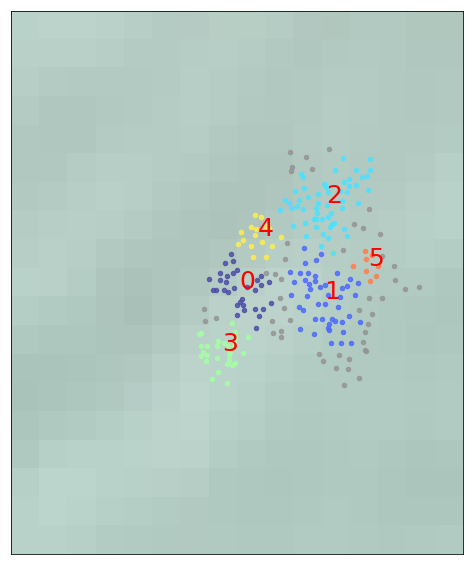

In [41]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc', lat_0 = latitude, lon_0 = longitude,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-84.75, llcrnrlat=33.5,
                 urcrnrlon=-84.25, urcrnrlat=34)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf_location2[pdf_location2.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        total = 0
        count = 0
        for hood in clust_set['Neighborhood']:
            #print(hood)
            x=num_crimes.Neighborhood[num_crimes.Neighborhood==hood].index.tolist()
            x1=x[0]
            total += num_crimes['Count'][x1]
            count += 1
        
        print ("Cluster "+str(clust_number)+', Avg Number of Crimes per Neighborhood: '+\
               str(total/count))

##### Visualization Based on Location and Larceny Crimes

Larceny the most-committed crime, see below

##### Re-run DBSCAN for new variables

In [42]:
atl_crime_grouped2018 = atl_onehot.groupby('Neighborhood').sum().reset_index()
atl_crime_grouped2018['Lat']=pdf_loc['Lat']
atl_crime_grouped2018['Long']=pdf_loc['Long']
atl_crime_grouped2018.head(5)

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long
0,Adair Park,14.0,37.0,4.0,16.0,0.0,75.0,34.0,0.0,3.0,12.0,2.0,33.730508,-84.410038
1,Adams Park,6.0,14.0,11.0,10.0,0.0,22.0,26.0,0.0,3.0,2.0,3.0,33.714968,-84.461356
2,Adamsville,21.0,39.0,11.0,11.0,2.0,59.0,52.0,0.0,4.0,15.0,2.0,33.759220,-84.503682
3,Almond Park,6.0,9.0,2.0,9.0,1.0,7.0,5.0,0.0,1.0,6.0,0.0,33.783619,-84.460499
4,Amal Heights,2.0,6.0,0.0,2.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,33.708469,-84.398998


In [43]:
pdf_location.columns

Index(['Neighborhood', 'AGG ASSAULT', 'AUTO THEFT', 'BURGLARY-NONRES',
       'BURGLARY-RESIDENCE', 'HOMICIDE', 'LARCENY-FROM VEHICLE',
       'LARCENY-NON VEHICLE', 'MANSLAUGHTER', 'ROBBERY-COMMERCIAL',
       'ROBBERY-PEDESTRIAN', 'ROBBERY-RESIDENCE', 'Lat', 'Long', 'xm', 'ym',
       'Clus_Db'],
      dtype='object')

In [96]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = atl_crime_grouped2018[['LARCENY-FROM VEHICLE', 'LARCENY-NON VEHICLE', 'Lat', 'Long']] #'Lat', 'Long',
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
#E = np.arange(.01, 2.5, .001)
n_list = []
#count=.01
#for e in E:
    
db = DBSCAN(eps=.454, min_samples=3).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf_loc = pdf
pdf_loc["Clus_Db"]=labels
    
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
    
    
    
n=set(labels)
n_list.append(len(n))
    
    #trials = pd.DataFrame(pdf_loc['Clus_Db'].value_counts())
    #trials = trials.reset_index()
    #i_list = trials['index'].tolist()
    #clus_list = trials['index'].tolist()
    #if trials['index'][0] != -1 and len(i_list)>2:
    #    #if min(clus_list)==
    #    print(count)
    #    print(trials.head())
    #count+=.001
    



# A sample of clusters
#pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)
pdf_loc.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,4
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,0
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,1


In [97]:
set(labels)

{-1, 0, 1, 2, 3, 4}

In [98]:
pdf_loc['Clus_Db'].value_counts()

 0    107
 2     48
-1     43
 1     28
 4      4
 3      4
Name: Clus_Db, dtype: int64

In [99]:
pdf_location3 = pdf_location
pdf_location3['Clus_Db']=pdf_loc['Clus_Db']
pdf_location3.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,4
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,0
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,1


Cluster 0, Avg Number of Larceny Crimes per Neighborhood: 40.83177570093458
Cluster 1, Avg Number of Larceny Crimes per Neighborhood: 65.46428571428571
Cluster 2, Avg Number of Larceny Crimes per Neighborhood: 34.833333333333336
Cluster 3, Avg Number of Larceny Crimes per Neighborhood: 25.0
Cluster 4, Avg Number of Larceny Crimes per Neighborhood: 185.5


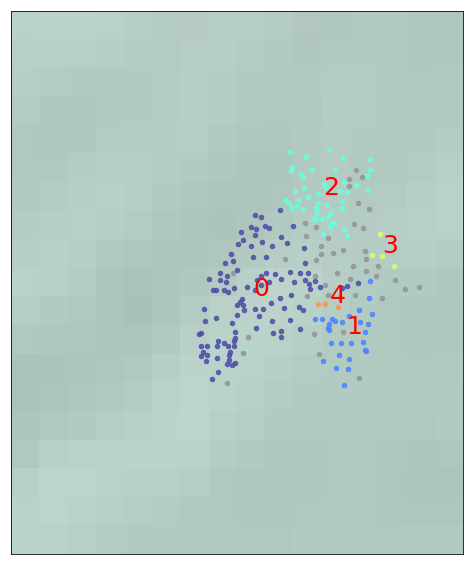

In [48]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc', lat_0 = latitude, lon_0 = longitude,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-84.75, llcrnrlat=33.5,
                 urcrnrlon=-84.25, urcrnrlat=34)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf_location3[pdf_location3.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        total = 0
        count = 0
        for hood in clust_set['Neighborhood']:
            #print(hood)
            x=num_crimes.Neighborhood[num_crimes.Neighborhood==hood].index.tolist()
            x1=x[0]
            total += num_crimes['Count'][x1]
            count += 1
        
        print ("Cluster "+str(clust_number)+', Avg Number of Larceny Crimes per Neighborhood: '+\
               str(total/count))

##### Visualization Based on Violent Crimes(AGG ASSAULT and HOMICIDE) and Location

In [103]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = atl_crime_grouped2018[['HOMICIDE','AGG ASSAULT', 'Lat', 'Long']] #'Lat', 'Long',
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
#E = np.arange(.01, 2.5, .001)
#n_list = []
#count=.01
#for e in E:
    
db = DBSCAN(eps=.492, min_samples=3).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf_loc = pdf
pdf_loc["Clus_Db"]=labels
    
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
    
    
    
n=set(labels)
n_list.append(len(n))
    
    #trials = pd.DataFrame(pdf_loc['Clus_Db'].value_counts())
    #trials = trials.reset_index()
    #i_list = trials['index'].tolist()
    #clus_list = trials['index'].tolist()
    #if trials['index'][0] != -1 and len(i_list)>3:
    #    #if min(clus_list)==
    #    print(count)
    #    print(set(labels))
    #    print(trials.head())
    #count+=.001
    



# A sample of clusters
#pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)
pdf_loc.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,0
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,0


In [104]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [105]:
pdf_location4 = pdf_location
pdf_location4['Clus_Db']=pdf_loc['Clus_Db']
pdf_location4.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,0
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,0


Cluster 0, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 48.742574257425744
Cluster 1, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 48.5
Cluster 2, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 73.0
Cluster 3, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 27.666666666666668
Cluster 4, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 168.66666666666666
Cluster 5, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 83.66666666666667
Cluster 6, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 149.33333333333334
Cluster 7, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 15.0


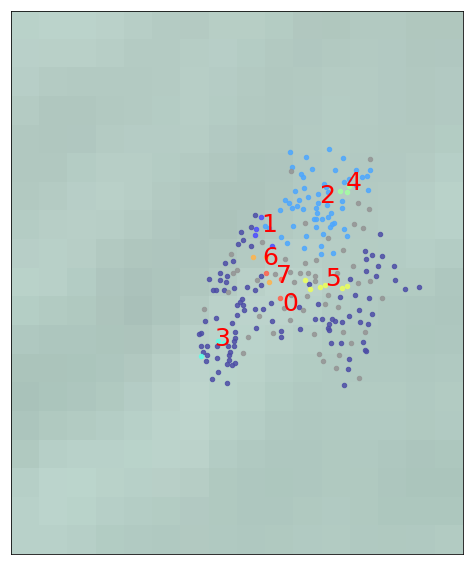

In [52]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc', lat_0 = latitude, lon_0 = longitude,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-84.75, llcrnrlat=33.5,
                 urcrnrlon=-84.25, urcrnrlat=34)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf_location4[pdf_location4.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        total = 0
        count = 0
        for hood in clust_set['Neighborhood']:
            #print(hood)
            x=num_crimes.Neighborhood[num_crimes.Neighborhood==hood].index.tolist()
            x1=x[0]
            total += num_crimes['Count'][x1]
            count += 1
        
        print ("Cluster "+str(clust_number)+', Avg Number of Homicide/Agg Assault Crimes per Neighborhood: '+\
               str(total/count))

##### Visualization Based on Violent Crimes(Robbery) and Location

In [110]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = atl_crime_grouped2018[['ROBBERY-COMMERCIAL','ROBBERY-PEDESTRIAN',\
                                      'ROBBERY-RESIDENCE', 'Lat', 'Long']] #'Lat', 'Long',
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
#E = np.arange(.01, 2.5, .001)
#n_list = []
#count=.01
#for e in E:
    
db = DBSCAN(eps=.573, min_samples=3).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf_loc = pdf
pdf_loc["Clus_Db"]=labels
    
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
    
    
    
n=set(labels)
n_list.append(len(n))
    
    #trials = pd.DataFrame(pdf_loc['Clus_Db'].value_counts())
    #trials = trials.reset_index()
    #i_list = trials['index'].tolist()
    #clus_list = trials['index'].tolist()
    #if trials['index'][0] != -1 and len(i_list)>3:
    #    #if min(clus_list)==
    #    print(count)
    #    print(set(labels))
    #    print(trials.head())
    #count+=.001
    



# A sample of clusters
#pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)
pdf_loc.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,-1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,-1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,0


In [111]:
pdf_location5 = pdf_location
pdf_location5['Clus_Db']=pdf_loc['Clus_Db']
pdf_location5.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,-1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,-1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,0


Cluster 0, Avg Number of Robbery Crimes per Neighborhood: 19.564705882352943
Cluster 1, Avg Number of Robbery Crimes per Neighborhood: 59.98148148148148
Cluster 2, Avg Number of Robbery Crimes per Neighborhood: 104.25
Cluster 3, Avg Number of Robbery Crimes per Neighborhood: 37.0
Cluster 4, Avg Number of Robbery Crimes per Neighborhood: 20.5
Cluster 5, Avg Number of Robbery Crimes per Neighborhood: 42.0
Cluster 6, Avg Number of Robbery Crimes per Neighborhood: 93.66666666666667


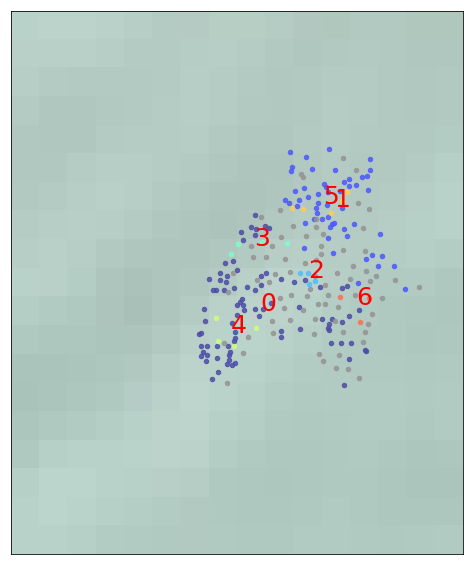

In [55]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc', lat_0 = latitude, lon_0 = longitude,
                 resolution = 'l', area_thresh = 0.1,
                 llcrnrlon=-84.75, llcrnrlat=33.5,
                 urcrnrlon=-84.25, urcrnrlat=34)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf_location5[pdf_location5.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        total = 0
        count = 0
        for hood in clust_set['Neighborhood']:
            #print(hood)
            x=num_crimes.Neighborhood[num_crimes.Neighborhood==hood].index.tolist()
            x1=x[0]
            total += num_crimes['Count'][x1]
            count += 1
        
        print ("Cluster "+str(clust_number)+', Avg Number of Robbery Crimes per Neighborhood: '+\
               str(total/count))

In [107]:
xx=[]
yy=[]
for x,y in zip(lats, lons):
    xx.append(x)
    yy.append(y)
xx[0:10]

[33.73050822335027,
 33.714967551020436,
 33.759219723502326,
 33.783619130434786,
 33.708468888888895,
 33.7931701851852,
 33.83800333333333,
 33.80427095890408,
 33.84127142857143,
 33.691722222222225]

#### NPUs with Most Crime

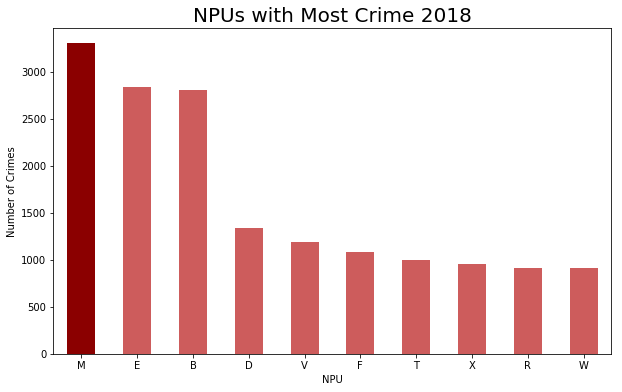

In [56]:
hood_crime = atl_crime['NPU'].value_counts()
hood_crime10 = hood_crime[0:10]

top_10 = hood_crime10.plot(kind='bar', color = 'indianred', figsize=(10, 6))
top_10.patches[hood_crime10.index.get_indexer(['M'])[0]].set_facecolor('darkred')

plt.xlabel('NPU') # add to x-label to the plot
plt.ylabel('Number of Crimes') # add y-label to the plot
plt.title('NPUs with Most Crime 2018', fontsize=20) # add title to the plot
plt.xticks(rotation=0)

               
plt.show()

It is interesting to note that although 2 neighborhoods(Downtown, Midtown) distinctly separated themselves in number of crimes, the disparity between number of NPU(neighborhood conglomerates) crimes is not as great.

**Neighborhoods in NPU M:** Castleberry Hill, Downtown, Old Fourth Ward, Sweet Auburn

#### Most Common Crimes

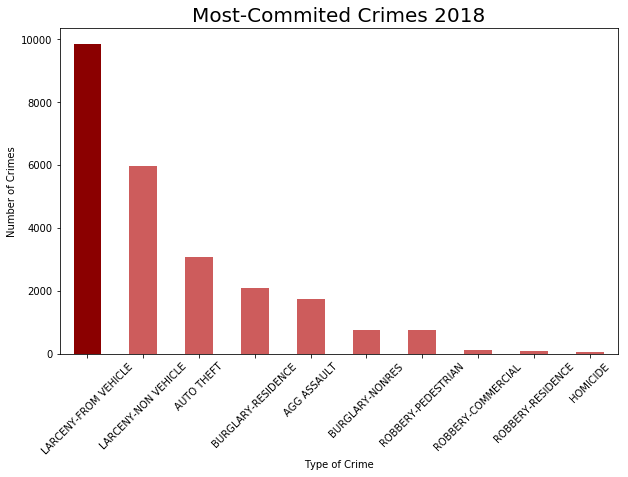

In [57]:
hood_crime = atl_crime['Type'].value_counts()
hood_crime10 = hood_crime[0:10]

top_10 = hood_crime10.plot(kind='bar', color = 'indianred', figsize=(10, 6))
top_10.patches[hood_crime10.index.get_indexer(['LARCENY-FROM VEHICLE'])[0]].set_facecolor('darkred')

plt.xlabel('Type of Crime') # add to x-label to the plot
plt.ylabel('Number of Crimes') # add y-label to the plot
plt.title('Most-Commited Crimes 2018', fontsize=20) # add title to the plot
plt.xticks(rotation=45)
               
plt.show()

#### Violent Crimes

In [58]:
# Violent Crimes as available by Atlanta PD dataset
homicide = atl_crime.query('Type == "HOMICIDE"')
agg_assault = atl_crime.query('Type == "AGG ASSAULT"')
rob_ped = atl_crime.query('Type == "ROBBERY-PEDESTRIAN"')
rob_com = atl_crime.query('Type == "ROBBERY-COMMERCIAL"')
rob_res = atl_crime.query('Type == "ROBBERY-RESIDENCE"')

frames = [homicide, agg_assault, rob_ped, rob_com, rob_res]
violent_crimes = pd.concat(frames, sort=False)

violent_crimes = violent_crimes.reset_index()
violent_crimes.drop('index', axis=1, inplace = True)
print(violent_crimes.shape)
violent_crimes.head()

    
    

(2831, 5)


,Type,Neighborhood,NPU,Lat,Long
0,HOMICIDE,Wildwood Forest,P,33.68442,-84.53966
1,HOMICIDE,Peoplestown,V,33.72755,-84.39278
2,HOMICIDE,Cascade Heights,I,33.71564,-84.47452
3,HOMICIDE,Mozley Park,K,33.75083,-84.44341
4,HOMICIDE,Kings Forest,P,33.69525,-84.51089


#### Violent Crime by Neighborhood

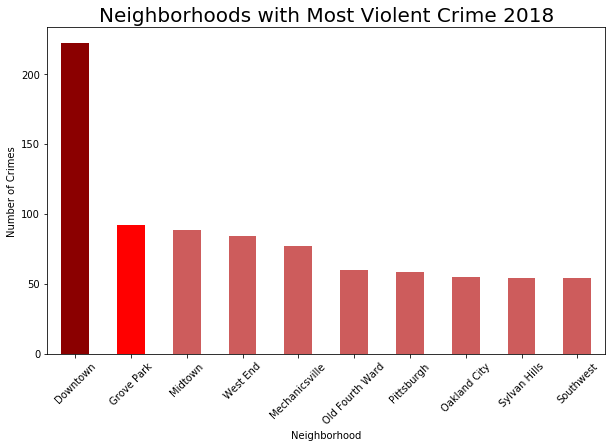

In [59]:
hood_crime = violent_crimes['Neighborhood'].value_counts()
hood_crime10 = hood_crime[0:10]

top_10 = hood_crime10.plot(kind='bar', color = 'indianred',figsize=(10, 6))
top_10.patches[hood_crime10.index.get_indexer(['Downtown'])[0]].set_facecolor('darkred')
top_10.patches[hood_crime10.index.get_indexer(['Grove Park'])[0]].set_facecolor('red')

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Crimes') # add y-label to the plot
plt.title('Neighborhoods with Most Violent Crime 2018', fontsize = 20)
plt.xticks(rotation=45)

plt.show()

Grove Park, which was not even in the top 10 for total crimes, is the second-highest for violent crimes among neighborhoods.

### **Location Data**

#### Clustering Venue Data and Data Exploration (Independent of Crime Clusters)

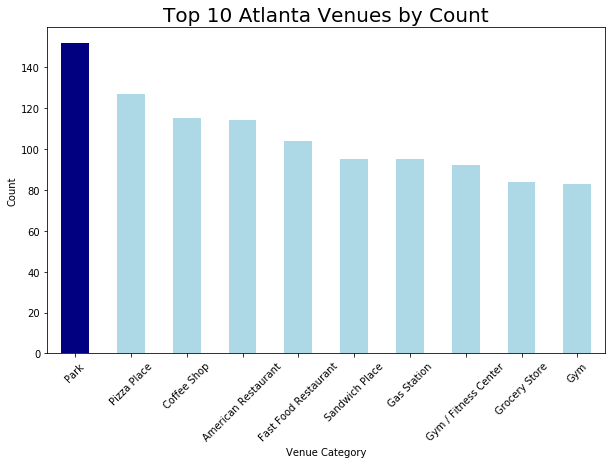

In [60]:
venue_counts = atlanta_venues['Venue Category'].value_counts()
venue_counts10 = venue_counts[0:10]


top_10 = venue_counts10.plot(kind='bar', color = 'lightblue', figsize=(10, 6))
top_10.patches[venue_counts10.index.get_indexer(['Park'])[0]].set_facecolor('navy')

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Top 10 Atlanta Venues by Count', fontsize=20) # add title to the plot
plt.xticks(rotation=45)
               
plt.show()


We can see that parks are the most common occurring venue in Atlanta neighborhoods, although there does not seem to be a huge disparity from one category to the next looking at the top 10. As someone from Atlanta, I did not realize how many parks there were! (Although there could be some double-counting in our data, as one park could be within half a mile of the crime-center of multiple neighborhoods, there are still more parks than I thought there were).

**How Many Venues for Each Neighborhood?**

In [61]:
atlanta_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adair Park,12,12,12,12,12,12
Adams Park,4,4,4,4,4,4
Adamsville,17,17,17,17,17,17
Almond Park,3,3,3,3,3,3
Amal Heights,5,5,5,5,5,5
Ansley Park,68,68,68,68,68,68
Arden/Habersham,5,5,5,5,5,5
Ardmore,47,47,47,47,47,47
Argonne Forest,9,9,9,9,9,9


**How Many Unique Venue Categories?**

In [62]:
print('There are {} uniques categories.'.format(len(atlanta_venues['Venue Category'].unique())))

There are 331 uniques categories.


#### Analyze Each Neighborhood

In [63]:
# one hot encoding
atl_venues_onehot = pd.get_dummies(atlanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atl_venues_onehot['Neighborhood'] = atlanta_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atl_venues_onehot.columns[-1]] + list(atl_venues_onehot.columns[:-1])
atl_venues_onehot = atl_venues_onehot[fixed_columns]

atl_venues_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Volleyball Court,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group by mean frequency

In [64]:
atl_venues_grouped = atl_venues_onehot.groupby('Neighborhood').mean().reset_index()
atl_venues_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create pandas dataframe to store top 10 venue-type of each neighborhood

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
atlanta_venues_sorted = pd.DataFrame(columns=columns)
atlanta_venues_sorted['Neighborhood'] = atl_venues_grouped['Neighborhood']

for ind in np.arange(atl_venues_grouped.shape[0]):
    atlanta_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atl_venues_grouped.iloc[ind, :], num_top_venues)

atlanta_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,Park,Trail,Brewery,Art Gallery,Beer Store,Event Space,Gastropub,Pop-Up Shop,Real Estate Office,American Restaurant
1,Adams Park,Park,Vacation Rental,Golf Course,Business Service,Zoo,Field,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
2,Adamsville,Fast Food Restaurant,Discount Store,Liquor Store,Food,Gym / Fitness Center,Roller Rink,Seafood Restaurant,Gas Station,Chinese Restaurant,Fried Chicken Joint
3,Almond Park,Bowling Alley,Park,Auto Workshop,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
4,Amal Heights,Music Venue,Bar,Non-Profit,Hotel,Trail,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm


#### Cluster Neighborhoods

In [67]:
from sklearn.cluster import KMeans 

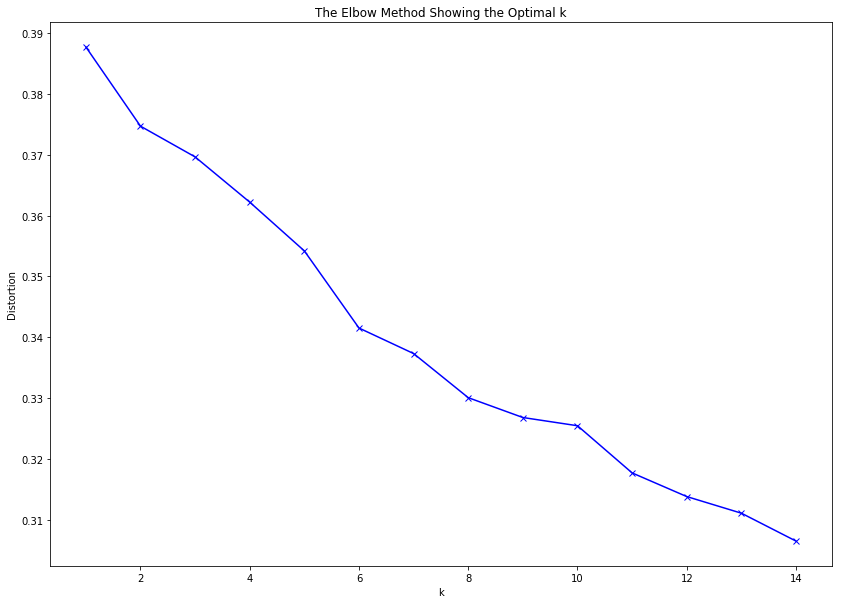

In [68]:
# k means determine k
atl_venues_clustering = atl_venues_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=4).fit(atl_venues_clustering)
    kmeanModel.fit(atl_venues_clustering)
    distortions.append(sum(np.min(cdist(atl_venues_clustering,\
                                        kmeanModel.cluster_centers_, 'euclidean'),\
                                        axis=1)) / atl_venues_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

In [69]:
# set number of clusters
kclusters = 9

atlanta_venues_clustering = atl_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atlanta_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ #[0:10]

array([1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 5, 4, 1, 4, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 5, 1, 1, 1, 1, 4, 1, 8, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 3, 3, 5, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1,
       4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0, 4, 4, 1, 1, 5,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1,
       1, 7, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 4, 1, 4], dtype=int32)

In [70]:
#atlanta_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
print(atlanta_venues_sorted.shape)
print(df_coord.shape)
set1 = set(atlanta_venues_sorted['Neighborhood'].to_list())
set2 = set(df_coord['Neighborhood'].to_list())
print(set2.difference(set1))
#atlanta_venues_sorted.head()

(233, 11)
(234, 4)
{'Wildwood Forest'}


In [71]:
atl_merged2.head()

NameError: name 'atl_merged2' is not defined

In [72]:
# add clustering labels
atlanta_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

atl_merged2 = df_coord
atl_merged2.drop([163,228], inplace=True)

# merge atl_grouped with toronto_data to add latitude/longitude for each neighborhood
atl_merged2 = atl_merged2.join(atlanta_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(atl_merged2.shape)
atl_merged2.head()

(232, 15)


,Neighborhood,NPU,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,V,33.730508,-84.410038,1,Park,Trail,Brewery,Art Gallery,Beer Store,Event Space,Gastropub,Pop-Up Shop,Real Estate Office,American Restaurant
1,Adams Park,R,33.714968,-84.461356,4,Park,Vacation Rental,Golf Course,Business Service,Zoo,Field,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
2,Adamsville,H,33.759220,-84.503682,1,Fast Food Restaurant,Discount Store,Liquor Store,Food,Gym / Fitness Center,Roller Rink,Seafood Restaurant,Gas Station,Chinese Restaurant,Fried Chicken Joint
3,Almond Park,G,33.783619,-84.460499,4,Bowling Alley,Park,Auto Workshop,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
4,Amal Heights,Y,33.708469,-84.398998,1,Music Venue,Bar,Non-Profit,Hotel,Trail,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm


In [73]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atl_merged2['Lat'], atl_merged2['Long'], atl_merged2['Neighborhood'], atl_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### DBSCAN Clustering Based on Venues

In [75]:
pdf_venue = atl_venues_grouped
pdf_venue['Lat'] = atl_merged2['Lat']
pdf_venue['Long'] = atl_merged2['Long']
#pdf_venue.drop(['Clus_Db'], axis=1, inplace=True)
print(pdf_venue.shape)
pdf_venue.head(10)

(233, 333)


,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long
0,Adair Park,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.730508,-84.410038
1,Adams Park,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.714968,-84.461356
2,Adamsville,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.759220,-84.503682
3,Almond Park,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.783619,-84.460499
4,Amal Heights,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.708469,-84.398998
5,Ansley Park,0.0,0.0,0.014706,0.0,0.044118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.793170,-84.378400
6,Arden/Habersham,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,33.838003,-84.401703
7,Ardmore,0.0,0.0,0.000000,0.0,0.021277,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.021277,0.0,33.804271,-84.394102
8,Argonne Forest,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.0,33.841271,-84.403490
9,Arlington Estates,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,33.691722,-84.539251


Per the cited article at the beginning, crime rates may be higher around locations that ssell alcohol so we will keep this in mind with our DBSCAN clusters

In [76]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = atl_venues_grouped[['Bar', 'Convenience Store', 'Liquor Store']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
#E = np.arange(.2, .5, .001)
n_list = []
#count=.2
#for e in E:
    
db = DBSCAN(eps=.255, min_samples=4).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf_loc = pdf_venue
pdf_loc["Clus_Db"]=labels+1
    
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
    
    
    
n=set(labels)
n_list.append(len(n))
    
    #trials = pd.DataFrame(pdf_loc['Clus_Db'].value_counts())
    #trials = trials.reset_index()
    #i_list = trials['index'].tolist()
    #clus_list = trials['index'].tolist()
    #if trials['index'][0] != -1 and len(i_list)>2:
    #    #if min(clus_list)==
    #    print(count)
    #    print(trials.head())
    #count+=.001
    



# A sample of clusters
#pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)
pdf_loc.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long,Clus_Db
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.730508,-84.410038,1
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.714968,-84.461356,1
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.759220,-84.503682,2
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.783619,-84.460499,1
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.708469,-84.398998,0


In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters = 8
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atl_merged2['Lat'], atl_merged2['Long'], atl_merged2['Neighborhood'], pdf_loc['Clus_Db']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [78]:
venue_clus0 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 0, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
134,Lincoln Homes,Cocktail Bar,Zoo,Financial or Legal Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
148,Monroe Heights,Cocktail Bar,Zoo,Financial or Legal Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [79]:
venue_clus1 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 1, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,Park,Trail,Brewery,Art Gallery,Beer Store,Event Space,Gastropub,Pop-Up Shop,Real Estate Office,American Restaurant
2,Adamsville,Fast Food Restaurant,Discount Store,Liquor Store,Food,Gym / Fitness Center,Roller Rink,Seafood Restaurant,Gas Station,Chinese Restaurant,Fried Chicken Joint
4,Amal Heights,Music Venue,Bar,Non-Profit,Hotel,Trail,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm
5,Ansley Park,Park,Garden,Gay Bar,Restaurant,Trail,Sandwich Place,Coffee Shop,American Restaurant,Tennis Court,Southern / Soul Food Restaurant
6,Arden/Habersham,Music Venue,Wine Shop,Ski Trail,Speakeasy,Asian Restaurant,Zoo,Field,Eye Doctor,Falafel Restaurant,Farm


In [80]:
venue_clus2 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 2, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Boulder Park,Lake,Fish & Chips Shop,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
184,Ridgecrest Forest,Lake,Fish & Chips Shop,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
229,Wilson Mill Meadows,Lake,Fish & Chips Shop,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


In [81]:
venue_clus3 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 3, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,Fairburn Mays,Wings Joint,Beach,Zoo,Fish & Chips Shop,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
91,Fairburn Road/Wisteria Lane,Wings Joint,Zoo,Fish & Chips Shop,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [82]:
venue_clus4 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 4, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adams Park,Park,Vacation Rental,Golf Course,Business Service,Zoo,Field,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
3,Almond Park,Bowling Alley,Park,Auto Workshop,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
13,Atlanta Industrial Park,Intersection,Park,Soccer Field,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
20,Bankhead,Convenience Store,Park,Wings Joint,Gas Station,Zoo,Financial or Legal Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
26,Ben Hill Pines,Park,Cosmetics Shop,BBQ Joint,Pharmacy,Gas Station,French Restaurant,Fried Chicken Joint,Wings Joint,Food Court,Farmers Market


In [83]:
venue_clus5 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 5, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Ben Hill Forest,BBQ Joint,Women's Store,Fast Food Restaurant,Fish & Chips Shop,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Field
49,Butner/Tell,Stables,Fast Food Restaurant,Zoo,Financial or Legal Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Field
92,Fairburn Tell,Stables,Fast Food Restaurant,Zoo,Financial or Legal Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Field
105,Greenbriar Village,Recreation Center,Movie Theater,Fast Food Restaurant,Zoo,Fish & Chips Shop,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Field
128,Lake Estates,Fast Food Restaurant,Zoo,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Field,Financial or Legal Service,Fish & Chips Shop


In [84]:
venue_clus6 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 6, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus6.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Fairway Acres,Park,Zoo,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
172,Peyton Forest,Park,Zoo,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


In [85]:
venue_clus7 = atl_merged2.loc[atl_merged2['Cluster Labels'] == 7, atl_merged2.columns[[0] + list(range(5, atl_merged2.shape[1]))]]
venue_clus7.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
177,Polar Rock,Garden,Gas Station,Zoo,Fish & Chips Shop,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


## **RESULTS**

#### Determining Venue Breakdown in Neighborhoods based on Crime Clusters

Using the clusters formed from the crime data, we will see if the frequency of alchohol and/or weapon outlets is higher where the average occurence of crimes/a crime is higher.

**Breakdown using DBSCAN Clustering**

***Overall Crime, Location***

In [92]:
pdf_location2.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,0
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,4
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,1


In [93]:
#atl_venues_grouped.drop(['Clus_Db'], axis=1, inplace=True)
dbmeans1 = atl_venues_grouped.copy()
dbmeans1['Cluster Labels'] = pdf_location2['Clus_Db']
dbmeans1.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long,Clus_Db,Cluster Labels
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.730508,-84.410038,1,1
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.714968,-84.461356,1,-1
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.759220,-84.503682,2,0
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.783619,-84.460499,1,4
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.708469,-84.398998,0,1


In [94]:
dbmeansum1 = dbmeans1.groupby('Cluster Labels').mean().reset_index()
#dbmeansum1 = dbmeansum1.mul(10)
#dbmeansum1.head()

In [95]:
dbmeansum1[['Cluster Labels', 'Bar', 'Liquor Store', 'Convenience Store', 'Gun Shop', 'Pawn Shop']]

,Cluster Labels,Bar,Liquor Store,Convenience Store,Gun Shop,Pawn Shop
0,-1,0.006156,0.011016,0.005915,0.000000,0.003472
1,0,0.000000,0.019794,0.003472,0.000000,0.000000
2,1,0.012668,0.020356,0.047494,0.000000,0.002174
3,2,0.007990,0.006161,0.004645,0.000401,0.000000
4,3,0.000000,0.015230,0.011494,0.000000,0.000000
5,4,0.062500,0.022123,0.000000,0.000000,0.000000
6,5,0.059589,0.006300,0.001984,0.000000,0.000000


*And, if we recall,*

Cluster 0, Avg Number of Crimes per Neighborhood: 31.75

Cluster 1, Avg Number of Crimes per Neighborhood: 181.52173913043478

Cluster 2, Avg Number of Crimes per Neighborhood: 100.41818181818182

Cluster 3, Avg Number of Crimes per Neighborhood: 41.48275862068966

Cluster 4, Avg Number of Crimes per Neighborhood: 52.375

Cluster 5, Avg Number of Crimes per Neighborhood: 244.5

In [162]:
x = [1.0,2.0,3.0,4.0,5.0,6.0]
y = [4.0, 1.75, 3.5, 1.0, 3.0, 3.5]
df_overall = pd.DataFrame(y,x).reset_index()
df_overall.columns=['Rank','Score']
x_labels = ['Clus 5', 'Clus 1', 'Clus 2', 'Clus 4', 'Clus 3', 'Clus 0']
df_overall.head()

,Rank,Score
0,1.0,4.00
1,2.0,1.75
2,3.0,3.50
3,4.0,1.00
4,5.0,3.00


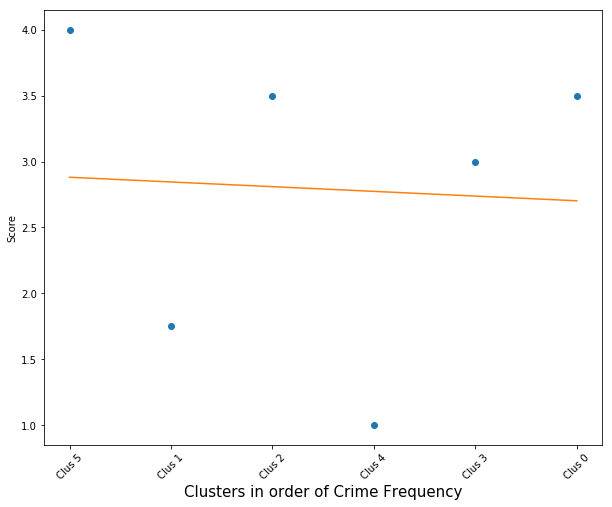

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from scipy import stats

plt.figure(figsize=(10,8))

xi = np.arange(0,6)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.scatter(x, y, c='r', alpha=0.5)
plt.plot(xi,y,'o', xi, line)
plt.xticks(range(6), x_labels, rotation=45, fontsize='10')
plt.xlabel('Clusters in order of Crime Frequency', fontsize='15')
plt.ylabel('Score')
plt.show()


***Larceny Crimes***

In [100]:
pdf_location3.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,4
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,0
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,1


In [101]:
dbmeans2 = atl_venues_grouped.copy()
dbmeans2['Cluster Labels'] = pdf_location3['Clus_Db']
dbmeans2.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long,Clus_Db,Cluster Labels
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.730508,-84.410038,1,4
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.714968,-84.461356,1,0
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.759220,-84.503682,2,-1
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.783619,-84.460499,1,0
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.708469,-84.398998,0,1


In [102]:
dbmeansum2 = dbmeans2.groupby('Cluster Labels').mean().reset_index()
dbmeansum2[['Cluster Labels', 'Bar', 'Liquor Store', 'Convenience Store', 'Gun Shop', 'Pawn Shop']]

,Cluster Labels,Bar,Liquor Store,Convenience Store,Gun Shop,Pawn Shop
0,-1,0.018291,0.016453,0.008708,0.000233,0.006202
1,0,0.010295,0.017794,0.019134,0.000000,0.000000
2,1,0.017037,0.017430,0.013837,0.000000,0.000000
3,2,0.006938,0.003783,0.003546,0.000247,0.000000
4,3,0.023810,0.000000,0.003968,0.000000,0.000000
5,4,0.000000,0.000000,0.047009,0.000000,0.000000


*If we recall,*

Cluster 0, Avg Number of Larceny Crimes per Neighborhood: 40.83177570093458

Cluster 1, Avg Number of Larceny Crimes per Neighborhood: 65.46428571428571

Cluster 2, Avg Number of Larceny Crimes per Neighborhood: 34.833333333333336

Cluster 3, Avg Number of Larceny Crimes per Neighborhood: 25.0

Cluster 4, Avg Number of Larceny Crimes per Neighborhood: 185.5

In [165]:
x = [1.0,2.0,3.0,4.0,5.0]
y = [1.0, 2.0, 1.67, 4.0, 3.5]
df_larceny= pd.DataFrame(y,x).reset_index()
df_larceny.columns=['Rank','Score']
x_labels = ['Clus 4', 'Clus 1', 'Clus 0', 'Clus 2', 'Clus 3']
df_larceny.head()

,Rank,Score
0,1.0,1.00
1,2.0,2.00
2,3.0,1.67
3,4.0,4.00
4,5.0,3.50


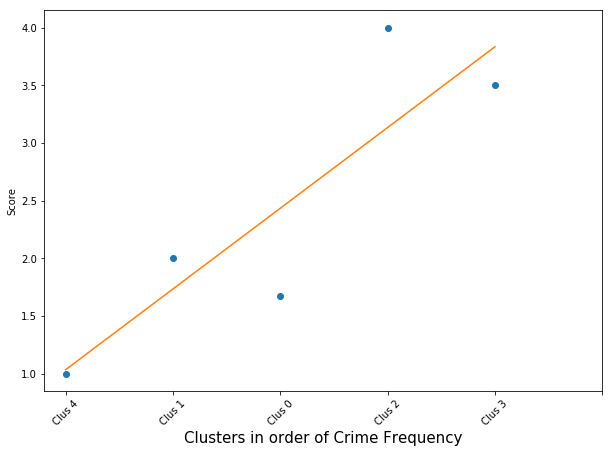

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from scipy import stats

plt.figure(figsize=(10,7))

xi = np.arange(0,5)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.scatter(x, y, c='r', alpha=0.5)
plt.plot(xi,y,'o', xi, line)
plt.xticks(range(6), x_labels, rotation=45, fontsize='10')
plt.xlabel('Clusters in order of Crime Frequency', fontsize='15')
plt.ylabel('Score')
plt.show()

***AGG Assault and Homicide***

In [107]:
pdf_location4.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,0
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,0
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,0


In [108]:
dbmeans3 = atl_venues_grouped.copy()
dbmeans3['Cluster Labels'] = pdf_location4['Clus_Db']
dbmeans3.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long,Clus_Db,Cluster Labels
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.730508,-84.410038,1,0
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.714968,-84.461356,1,0
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.759220,-84.503682,2,-1
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.783619,-84.460499,1,1
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.708469,-84.398998,0,0


In [115]:
dbmeansum3 = dbmeans3.groupby('Cluster Labels').mean().reset_index()
dbmeansum3[['Cluster Labels', 'Bar', 'Liquor Store', 'Convenience Store', 'Gun Shop', 'Pawn Shop']]

,Cluster Labels,Bar,Liquor Store,Convenience Store,Gun Shop,Pawn Shop
0,-1,0.025414,0.022124,0.033326,0.000192,0.005128
1,0,0.009459,0.017203,0.010400,0.000000,0.000000
2,1,0.000000,0.000000,0.000000,0.000000,0.000000
3,2,0.006656,0.005564,0.004059,0.000200,0.000000
4,3,0.000000,0.000000,0.000000,0.000000,0.000000
5,4,0.010000,0.000000,0.000000,0.000000,0.000000
6,5,0.015579,0.000000,0.026834,0.000000,0.000000
7,6,0.000000,0.022222,0.000000,0.000000,0.000000
8,7,0.000000,0.000000,0.000000,0.000000,0.000000


*If we recall,*

Cluster 0, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 48.742574257425744

Cluster 1, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 48.5

Cluster 2, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 73.0

Cluster 3, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 27.666666666666668

Cluster 4, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 168.66666666666666

Cluster 5, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 83.66666666666667

Cluster 6, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 149.33333333333334

Cluster 7, Avg Number of Homicide/Agg Assault Crimes per Neighborhood: 15.0

In [167]:
x = [1.0,2.0,3.0,4.0,5.0]
y = [2.0, 1.0, 1.0, 2.75, 2.33]
df_violent = pd.DataFrame(y,x).reset_index()
df_violent.columns=['Rank','Score']
x_labels = ['Clus 4', 'Clus 6', 'Clus 5', 'Clus 2', 'Clus 0']
df_violent.head()

,Rank,Score
0,1.0,2.00
1,2.0,1.00
2,3.0,1.00
3,4.0,2.75
4,5.0,2.33


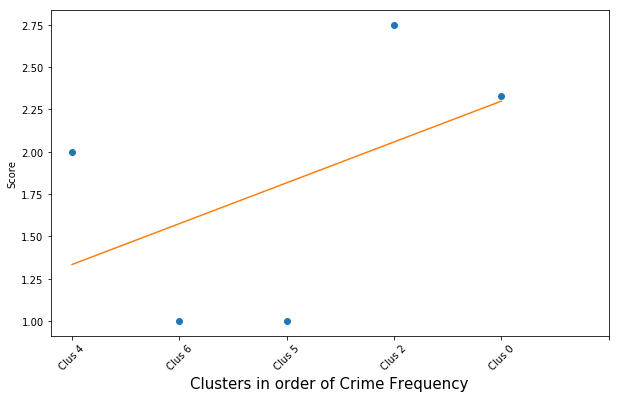

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from scipy import stats

plt.figure(figsize=(10,6))

xi = np.arange(0,5)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.scatter(x, y, c='r', alpha=0.5)
plt.plot(xi,y,'o', xi, line)
plt.xticks(range(6), x_labels, rotation=45, fontsize='10')
plt.xlabel('Clusters in order of Crime Frequency', fontsize='15')
plt.ylabel('Score')
plt.show()

***Robbery***

In [112]:
pdf_location5.head()

,Neighborhood,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE,Lat,Long,xm,ym,Clus_Db
0,Adair Park,0.071066,0.187817,0.020305,0.081218,0.000000,0.380711,0.172589,0.0,0.015228,0.060914,0.010152,33.730508,-84.410038,37802.040883,30778.301432,-1
1,Adams Park,0.061856,0.144330,0.113402,0.103093,0.000000,0.226804,0.268041,0.0,0.030928,0.020619,0.030928,33.714968,-84.461356,32095.742370,28700.661953,-1
2,Adamsville,0.097222,0.180556,0.050926,0.050926,0.009259,0.273148,0.240741,0.0,0.018519,0.069444,0.009259,33.759220,-84.503682,27389.321590,34617.744832,-1
3,Almond Park,0.130435,0.195652,0.043478,0.195652,0.021739,0.152174,0.108696,0.0,0.021739,0.130435,0.000000,33.783619,-84.460499,32190.988624,37881.564761,-1
4,Amal Heights,0.111111,0.333333,0.000000,0.111111,0.000000,0.388889,0.055556,0.0,0.000000,0.000000,0.000000,33.708469,-84.398998,39029.647974,27831.964397,0


In [113]:
dbmeans4 = atl_venues_grouped.copy()
dbmeans4['Cluster Labels'] = pdf_location5['Clus_Db']
dbmeans4.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Lat,Long,Clus_Db,Cluster Labels
0,Adair Park,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.730508,-84.410038,1,-1
1,Adams Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.714968,-84.461356,1,-1
2,Adamsville,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.759220,-84.503682,2,-1
3,Almond Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.783619,-84.460499,1,-1
4,Amal Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.708469,-84.398998,0,0


In [116]:
dbmeansum4 = dbmeans4.groupby('Cluster Labels').mean().reset_index()
dbmeansum4[['Cluster Labels', 'Bar', 'Liquor Store', 'Convenience Store', 'Gun Shop', 'Pawn Shop']]

,Cluster Labels,Bar,Liquor Store,Convenience Store,Gun Shop,Pawn Shop
0,-1,0.007461,0.017061,0.020800,0.000155,0.003556
1,0,0.005544,0.015190,0.009211,0.000000,0.000000
2,1,0.012948,0.005033,0.005016,0.000189,0.000000
3,2,0.000000,0.040509,0.136790,0.000000,0.000000
4,3,0.250000,0.027778,0.000000,0.000000,0.000000
5,4,0.000000,0.000000,0.000000,0.000000,0.000000
6,5,0.004348,0.000000,0.000000,0.000000,0.000000
7,6,0.015873,0.055556,0.007937,0.000000,0.000000


*If we recall,*

Cluster 0, Avg Number of Robbery Crimes per Neighborhood: 19.564705882352943

Cluster 1, Avg Number of Robbery Crimes per Neighborhood: 59.98148148148148

Cluster 2, Avg Number of Robbery Crimes per Neighborhood: 104.25

Cluster 3, Avg Number of Robbery Crimes per Neighborhood: 37.0

Cluster 4, Avg Number of Robbery Crimes per Neighborhood: 20.5

Cluster 5, Avg Number of Robbery Crimes per Neighborhood: 42.0

Cluster 6, Avg Number of Robbery Crimes per Neighborhood: 93.66666666666667

In [169]:
x = [1.0,2.0,3.0,4.0,5.0,6.0]
y = [1.5, 2.0, 4.0, 5.0, 2.0,3.33]
df_robb = pd.DataFrame(y,x).reset_index()
df_robb.columns=['Rank','Score']
x_labels = ['Clus 2', 'Clus 6', 'Clus 1', 'Clus 5', 'Clus 3', 'Clus 4']
df_robb.head()

,Rank,Score
0,1.0,1.5
1,2.0,2.0
2,3.0,4.0
3,4.0,5.0
4,5.0,2.0


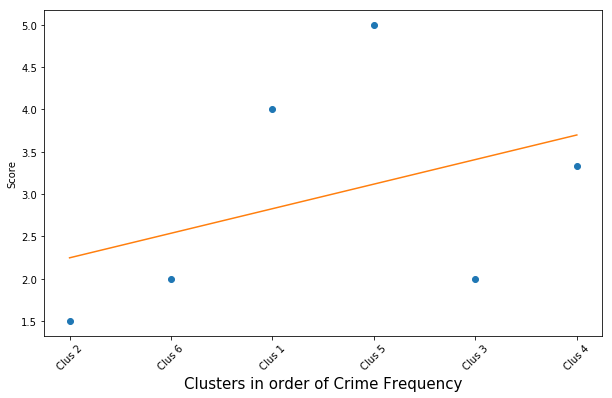

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from scipy import stats

plt.figure(figsize=(10,6))

xi = np.arange(0,6)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.scatter(x, y, c='r', alpha=0.5)
plt.plot(xi,y,'o', xi, line)
plt.xticks(range(6), x_labels, rotation=45, fontsize='10')
plt.xlabel('Clusters in order of Crime Frequency', fontsize='15')
plt.ylabel('Score')
plt.show()

## *Discussion*

Due to time constraints and my current knowledge with data science, not all methods were exhausted. For example, I could have included more variables associated with venues that serve/sell alcohol, among other things, but instead my results are derived from the description already given under the Results heading.

#### Observations

One of my goals was to search for correlations between venues traditionally associated with crime to see if it applied to Atlanta. For example, neighborhoods with more bars, liquor stores, etc would be expected to have higher crime rates by this logic. It is also important to remember that cluster sizes vary, so there may be variables that contribute to crime rates in specific areas that are unaccounted for in my results.

Using the crime rank and average scores given to each cluster I determined the correlations. For example, cluster with highest frequency of a particular venue received a 1, lowest a 6, and the applicable scores were averaged across. Only where a frequency greater than 0 occurred was taken into consideration. For example, a cluster with only 3 venues applicable would take the average rank only for 3 venues, not 5.

**Overall Crime(Location)**
Appears to be a negative correlation surprisingly. We would expect the score average to increase(meaning lower frequency of the targeted venues) by my hypothesis.

**Larceny Crimes**
The most common crime committed in Atlanta in 2018, there was a clear positive correlation between the frequency of the targeted venues and the average crime per neighborhood in the respective cluster.

**Agg Assualt/Homicide Crimes**
Although to a lesser extent than larceny crimes, there is still a clear positive relationship between the frequency of the targeted venues and the average crime per neighborhood in the clusters.

**Robbery Crimes**
Yet again, there is a positive correlation between the frequency of the targeted venues and the average number of robbery crimes per neighborhood committed in 2018.




## Conclusion

Based on these findings, I can conclude that there appears to be a positive correlation between the frequency alcohol-selling venues and crime(gun shops and pawn shops were included in finding the results but their mean freqency was usually 0 among clusters). There may be other variables at play that also contribute to crime, so it is not definitive that reducing alcohol-selling venues would guarantee a decrease in crime. However, it is something to keep in mind for various groups of people such as police officers, venue owners, citizens, and more.

Future research could better implement the DBSCAN and KMEANS clustering methods in an attempt to have a better idea of crime clusters. Also, more variables or different groups of venues could be analyzed to search for any correlations between venue-types and crime rates.
